<a href="https://colab.research.google.com/github/Rizvi999/neural-lab/blob/ex9/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Penn-Fudan dataset ready!
Using device: cpu
✅ Model loaded
Image: FudanPed00001.png, Predicted boxes: tensor([[159.9820, 177.8221, 300.1599, 433.0120],
        [414.6942, 168.5934, 533.8240, 486.3578],
        [279.5686, 238.4780, 309.5966, 281.2810],
        [257.2007, 171.7090, 307.8858, 279.4000],
        [499.7776, 142.2487, 559.0000, 317.9547],
        [267.8448, 232.1837, 303.5078, 279.9803],
        [136.4782, 139.7518, 294.1939, 310.1960],
        [295.8816, 238.7278, 322.0417, 280.1046]])


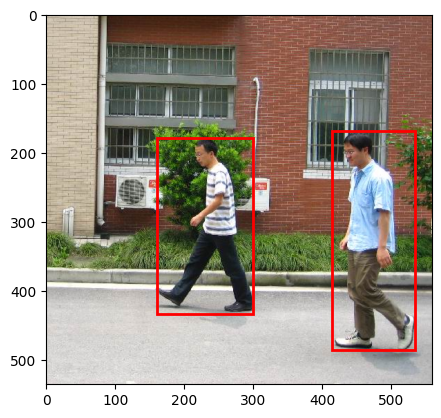

Image: FudanPed00002.png, Predicted boxes: tensor([[ 64.1340,  91.8284, 190.0248, 380.9976],
        [153.3220,  97.2970, 226.5280, 375.5144],
        [170.5161, 153.2804, 230.9220, 249.5466],
        [177.8427, 153.7297, 230.6530, 247.3117],
        [421.4675,   0.0000, 455.0000,  37.1690],
        [  1.8681, 127.6517,  40.4007, 189.4925],
        [433.4236, 162.9640, 454.5681, 256.0157]])


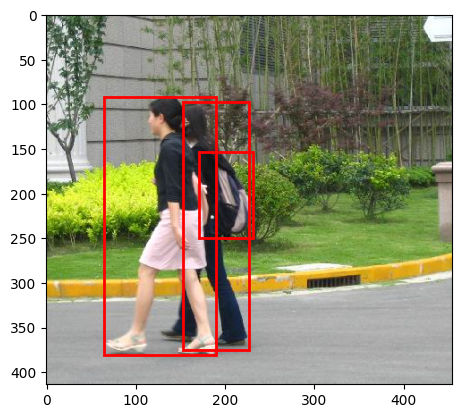

Image: FudanPed00003.png, Predicted boxes: tensor([[288.3217, 125.4523, 449.1881, 422.3347],
        [399.9515, 220.7506, 451.3973, 305.9915],
        [220.2903, 182.6188, 250.9253, 211.6944],
        [452.6639, 169.1399, 479.0000, 194.3450],
        [401.6730, 218.5982, 450.0186, 306.9349],
        [362.0479, 191.7305, 445.7910, 306.1999],
        [322.5808, 259.0370, 352.0462, 360.9330],
        [406.9616, 328.7438, 464.8204, 404.5557],
        [196.4400, 205.9241, 272.3130, 321.3530],
        [409.4268, 329.5672, 464.0508, 401.9315],
        [290.9319, 189.4945, 342.4630, 214.5310],
        [456.5742, 172.8075, 473.3694, 198.2629],
        [403.4018, 207.9567, 448.8514, 273.4803],
        [329.6930, 265.4869, 349.6006, 349.0027],
        [220.9986, 183.4380, 249.8842, 209.9199],
        [319.1946, 263.8970, 353.1938, 369.4051],
        [452.8640, 173.3768, 479.0000, 198.5652],
        [396.8506, 224.4303, 450.4117, 305.0492]])


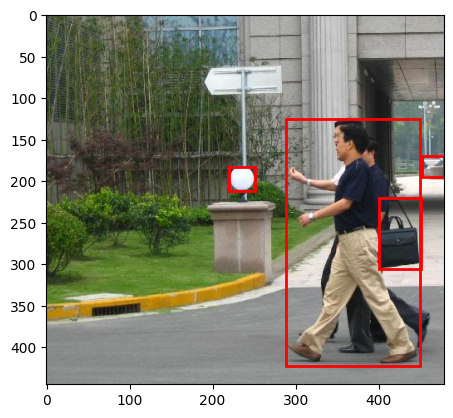

In [1]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.transforms import functional as F
from torch.utils.data import Dataset
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
import requests, zipfile

# -----------------------------
# 1. Download Penn-Fudan Dataset
# -----------------------------
if not os.path.exists("PennFudanPed"):
    url = "https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip"
    r = requests.get(url)
    with open("PennFudanPed.zip", "wb") as f:
        f.write(r.content)
    with zipfile.ZipFile("PennFudanPed.zip", "r") as zip_ref:
        zip_ref.extractall(".")
print("✅ Penn-Fudan dataset ready!")

# -----------------------------
# 2. Custom Dataset Loader
# -----------------------------
class PennFudanDataset(Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        if self.transforms:
            img = self.transforms(img)
        else:
            img = F.to_tensor(img)
        return img, self.imgs[idx]

    def __len__(self):
        return len(self.imgs)

# -----------------------------
# 3. Load Dataset
# -----------------------------
dataset = PennFudanDataset("PennFudanPed")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------
# 4. Load Pretrained Faster R-CNN
# -----------------------------
model = fasterrcnn_mobilenet_v3_large_fpn(weights="DEFAULT")
model.eval()
model.to(device)
print("✅ Model loaded")

# -----------------------------
# 5. Inference on all images
# -----------------------------
def show(img, boxes, scores, threshold=0.5):
    plt.imshow(img.permute(1,2,0))
    for i, box in enumerate(boxes):
        if scores[i] < threshold:
            continue
        x1, y1, x2, y2 = box
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, color='red', linewidth=2))
    plt.show()

for i in range(len(dataset)):
    img, fname = dataset[i]
    with torch.no_grad():
        prediction = model([img.to(device)])[0]
    print(f"Image: {fname}, Predicted boxes:", prediction["boxes"])
    show(img.cpu(), prediction["boxes"].cpu(), prediction["scores"].cpu(), threshold=0.5)
    if i==2:  # show only first 3 images for speed
        break
